## Introducción

Según el [artículo](https://research.fb.com/prophet-forecasting-at-scale/) de Facebook Research, Prophet se desarrolló inicialmente con el propósito de crear previsiones empresariales de alta calidad. Esta biblioteca trata de abordar las siguientes dificultades comunes a muchas series temporales empresariales:
- Efectos estacionales causados por el comportamiento humano: ciclos semanales, mensuales y anuales, caídas y picos en días festivos.
- Cambios de tendencia debidos a nuevos productos y acontecimientos del mercado.
- Valores atípicos.

Los autores afirman que, incluso con la configuración por defecto, en muchos casos su biblioteca produce previsiones tan precisas como las de analistas experimentados.

Además, Prophet dispone de una serie de personalizaciones intuitivas y fácilmente interpretables que permiten mejorar gradualmente la calidad del modelo de previsión. Lo que es especialmente importante, estos parámetros son bastante comprensibles incluso para los no expertos en análisis de series temporales, que es un campo de la ciencia de datos que requiere cierta habilidad y experiencia.

Por cierto, el artículo original se titula «Forecasting at Scale», pero no trata de la escala en el sentido «habitual», es decir, abordar los problemas computacionales y de infraestructura de un gran número de programas en funcionamiento. Según los autores, Prophet debe escalar bien en las 3 áreas siguientes:
- Accesibilidad a un amplio público de analistas, posiblemente sin profundos conocimientos en series temporales.
- Aplicabilidad a una amplia gama de problemas de previsión distintos.
- Estimación automatizada del rendimiento de un gran número de previsiones, incluida la señalización de problemas potenciales para su posterior inspección por parte del analista.

## El modelo de previsión de Prophet

Veamos ahora con más detalle cómo funciona Prophet. En su esencia, esta biblioteca utiliza el [modelo de regresión aditiva](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ que comprende los siguientes componentes:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$

donde:
* La tendencia $g(t)$ modela los cambios no periódicos.
* La estacionalidad $s(t)$ representa los cambios periódicos.
* El componente de vacaciones $h(t)$ aporta información sobre vacaciones y eventos.

A continuación, consideraremos algunas propiedades importantes de estos componentes del modelo.

### Tendencia

La biblioteca Prophet implementa dos posibles modelos de tendencia para $g(t)$.

El primero se llama *Nonlinear, Saturating Growth*. Se representa en la forma del [modelo de crecimiento logístico](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

donde:
* $C$ es la capacidad de carga (es decir, el valor máximo de la curva).
* $k$ es la tasa de crecimiento (que representa «la inclinación» de la curva).
* $m$ es un parámetro de compensación.

Esta ecuación logística permite modelizar el crecimiento no lineal con saturación, es decir, cuando la tasa de crecimiento de un valor disminuye con su crecimiento. Uno de los ejemplos típicos sería representar el crecimiento de la audiencia de una aplicación o una página web.

En realidad, $C$ y $k$ no son necesariamente constantes y pueden variar con el tiempo. Prophet admite tanto el ajuste automático como el manual de su variabilidad. La biblioteca puede elegir por sí misma los puntos óptimos de los cambios de tendencia ajustándose a los datos históricos suministrados. 

Además, Prophet permite a los analistas fijar manualmente los puntos de cambio de los valores de la tasa de crecimiento y la capacidad en distintos momentos del tiempo. Por ejemplo, los analistas pueden tener información sobre fechas de lanzamientos pasados que influyeron de forma destacada en algunos indicadores clave del producto.

El segundo modelo de tendencia es un simple *Modelo lineal por partes* con una tasa de crecimiento constante. Es el más adecuado para problemas sin crecimiento saturado.

### Estacionalidad

El componente estacional $s(t)$ proporciona un modelo flexible de los cambios periódicos debidos a la estacionalidad semanal y anual.

Los datos estacionales semanales se modelan con variables ficticias. Se añaden seis nuevas variables: `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, que toman valores 0 ó 1 según el día de la semana. La característica «domingo» no se añade porque sería una combinación lineal de los demás días de la semana, y este hecho tendría un efecto adverso en el modelo.

El modelo de estacionalidad anual de Prophet se basa en series de Fourier.

Desde la [versión 0.2](https://github.com/facebook/prophet) también puede utilizar *sub-series temporales diarias* y realizar *previsiones subdiarias*, así como emplear la nueva función de *estacionalidad diaria*.

### Días festivos y eventos

El componente $h(t)$ representa los días anormales previsibles del año, incluidos los de calendario irregular, por ejemplo, los Viernes Negros.

Para utilizar esta función, el analista debe proporcionar una lista personalizada de eventos.

### Error

El término de error $\epsilon(t)$ representa información no reflejada en el modelo. Normalmente se modela como ruido distribuido normalmente.

### Prophet Benchmarking

Para una descripción detallada del modelo y los algoritmos de Prophet, consulte el artículo [«Forecasting at scale»](https://peerj.com/preprints/3190/) de Sean J. Taylor y Benjamin Letham.

Los autores también compararon su biblioteca con otros métodos de previsión de series temporales. Utilizaron [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) como medida de la precisión de la predicción. En esta investigación, Prophet ha mostrado un error de previsión sustancialmente menor que los otros modelos.

<img src="https://mlcourse.ai/_static/img/topic9_benchmarking_prophet.png" />

Veamos con más detalle cómo se ha medido la calidad de las previsiones en el artículo. Para ello, necesitaremos la fórmula del error porcentual absoluto medio.

Sea $y_{i}$ el *valor real (histórico)* y $\hat{y}_{i}$ el *valor previsto* por nuestro modelo.

A continuación, $e_{i} = y_{i} - \hat{y}_{i}$ es el *error de previsión* y $p_{i} = \frac{e_{i}}{y_{i}}$ es el *error relativo de previsión*.

Definimos

$$MAPE = mean\big(\left |p_{i} \right |\big)$$

MAPE se utiliza ampliamente como medida de la precisión de la predicción porque expresa el error como porcentaje y, por tanto, puede utilizarse en evaluaciones de modelos en diferentes conjuntos de datos.

Además, al evaluar un algoritmo de predicción, puede resultar útil calcular [MAE (Error Medio Absoluto)](https://en.wikipedia.org/wiki/Mean_absolute_error) para tener una idea de los errores en números absolutos. Utilizando los componentes definidos anteriormente, su ecuación será

$$MAE = mean\big(\left |e_{i}\right |\big)$$

Unas palabras sobre los algoritmos con los que se comparó Prophet. La mayoría de ellos son bastante sencillos y suelen utilizarse como referencia para otros modelos:
* `naive` (ingenuo) es un enfoque de previsión simplista en el que predecimos todos los valores futuros basándonos únicamente en la observación en el último momento disponible.
* El modelo `snaive` (ingenuo estacional) realiza predicciones constantes teniendo en cuenta la información sobre la estacionalidad. Por ejemplo, en el caso de datos estacionales semanales, para cada lunes futuro se predeciría el valor del último lunes, y para todos los martes futuros se utilizaría el valor del último martes, y así sucesivamente.
* `mean` utiliza el valor medio de los datos como predicción.
* `arima` significa *Media Móvil Autorregresiva Integrada*, véase [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) para más detalles.
* `ets` significa *Alisamiento exponencial*, véase [Wikipedia](https://en.wikipedia.org/wiki/Exponential_smoothing) para más información.

## Facebook Prophet

En primer lugar, es necesario instalar la biblioteca. Prophet está disponible para Python y R. La elección dependerá de tus preferencias personales y de los requisitos del proyecto. En este artículo utilizaremos Python.

En Python puedes instalar Prophet usando PyPI:

In [2]:
# !pip install prophet

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

### Dataset

Emplearemos los conjuntos de datos vistos anteriormente.

In [4]:
df = pd.read_csv('data/a10.csv')
df

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [5]:
df['date'] = pd.to_datetime(df['date'])

### Análisis visual exploratorio

Como siempre, puede resultar útil e instructivo observar una representación gráfica de los datos.

Crearemos un gráfico de series temporales para todo el intervalo de tiempo. La visualización de los datos durante un periodo de tiempo tan largo puede dar pistas sobre la estacionalidad y las desviaciones anormales llamativas.

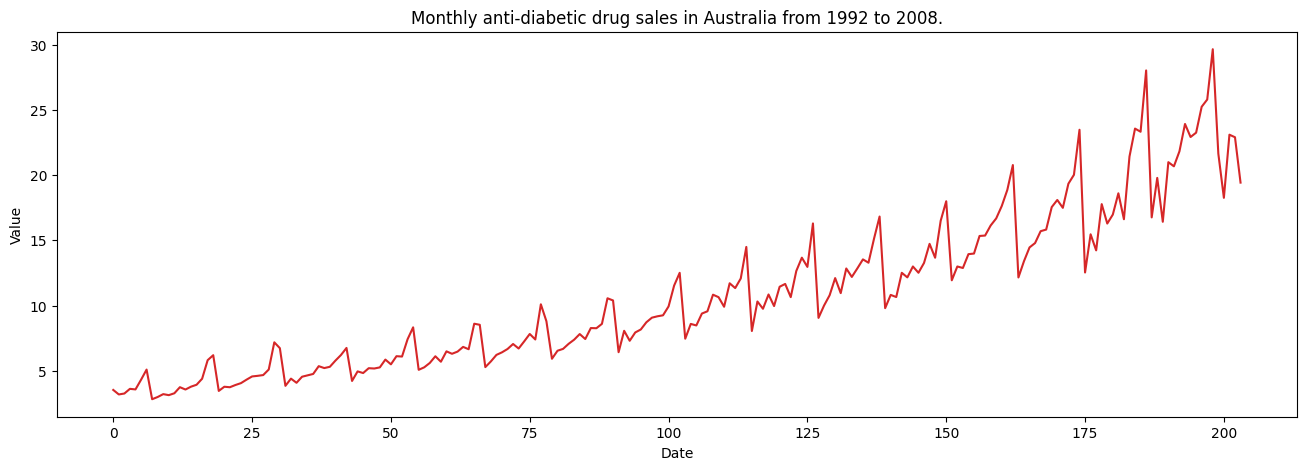

In [6]:
import matplotlib.pyplot as plt

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.') 

### Hacer una predicción

La API de Prophet es muy similar a la que puedes encontrar en `sklearn`. Primero creamos un modelo, luego llamamos al método `fit`, y, finalmente, hacemos una previsión. La entrada del método `fit` es un `DataFrame` con dos columnas:
* `ds` (datestamp) debe ser de tipo `date` o `datetime`.
* Y es un valor numérico que queremos predecir.

Para empezar, importaremos la librería y silenciaremos los mensajes de diagnóstico sin importancia:

In [7]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Let's convert our dataframe to the format required by Prophet:

In [8]:
df

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [9]:
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


Los autores de la biblioteca suelen aconsejar hacer predicciones basadas en al menos varios meses, e idealmente, más de un año de datos históricos. Por suerte, en nuestro caso tenemos más de un par de años de datos para ajustar el modelo.

Para medir la calidad de nuestra previsión, tenemos que dividir nuestro conjunto de datos en la *parte histórica*, que es la primera y mayor porción de nuestros datos, y la *parte de predicción*, que se situará al final de la línea temporal. Eliminaremos el último mes del conjunto de datos para utilizarlo posteriormente como objetivo de predicción:

In [10]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291


Ahora necesitamos crear un nuevo objeto `Prophet`. Aquí podemos pasar los parámetros del modelo en el constructor. Pero en este artículo vamos a utilizar los valores por defecto. Luego entrenamos nuestro modelo invocando su método `fit` en nuestro conjunto de datos de entrenamiento:

In [11]:
m = Prophet()
m.fit(train_df);

18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:13 - cmdstanpy - INFO - Chain [1] done processing


Usando el método de ayuda `Prophet.make_future_dataframe`, creamos un marco de datos que contendrá todas las fechas de la historia y también se extenderá hacia el futuro para esos 30 días que dejamos fuera antes.

In [15]:
future = m.make_future_dataframe(periods=prediction_size, freq='MS')
future.tail(n=3)

,ds
201,2008-04-01
202,2008-05-01
203,2008-06-01


Predecimos valores con `Prophet` introduciendo las fechas para las que queremos crear una predicción. Si también proporcionamos las fechas históricas (como en nuestro caso), además de la predicción obtendremos un ajuste dentro de la muestra para la historia. Llamemos al método `predict` del modelo con nuestro marco de datos `future` como entrada:

In [17]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
201,2008-04-01,20.627639,18.649982,20.350723,20.483903,20.760276,-1.079870,-1.079870,-1.079870,-1.079870,-1.079870,-1.079870,0.0,0.0,0.0,19.547770
202,2008-05-01,20.746033,19.169521,20.868925,20.592720,20.883674,-0.705216,-0.705216,-0.705216,-0.705216,-0.705216,-0.705216,0.0,0.0,0.0,20.040817
203,2008-06-01,20.868373,19.202407,20.805581,20.708784,21.016052,-0.809357,-0.809357,-0.809357,-0.809357,-0.809357,-0.809357,0.0,0.0,0.0,20.059016


En el marco de datos resultante puede ver muchas columnas que caracterizan la predicción, incluidos los componentes de tendencia y estacionalidad, así como sus intervalos de confianza. La propia predicción se almacena en la columna `yhat`.

La biblioteca Prophet tiene sus propias herramientas de visualización que nos permiten evaluar rápidamente el resultado.

En primer lugar, existe un método llamado `Prophet.plot` que traza todos los puntos de la previsión:

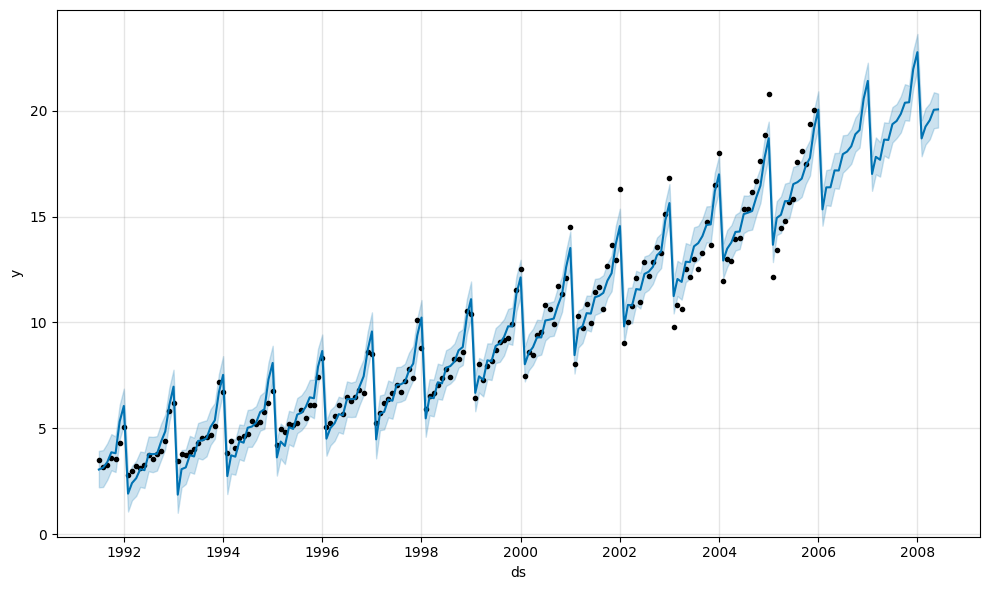

In [18]:
m.plot(forecast);

Este gráfico no parece muy informativo. La única conclusión definitiva que podemos sacar aquí es que el modelo trató muchos de los puntos de datos como valores atípicos.

La segunda función `Prophet.plot_components` podría ser mucho más útil en nuestro caso. Nos permite observar por separado los distintos componentes del modelo: tendencia, estacionalidad anual y semanal. Además, si proporcionas información sobre días festivos y eventos a tu modelo, también se mostrarán en este gráfico.

Vamos a probarlo:

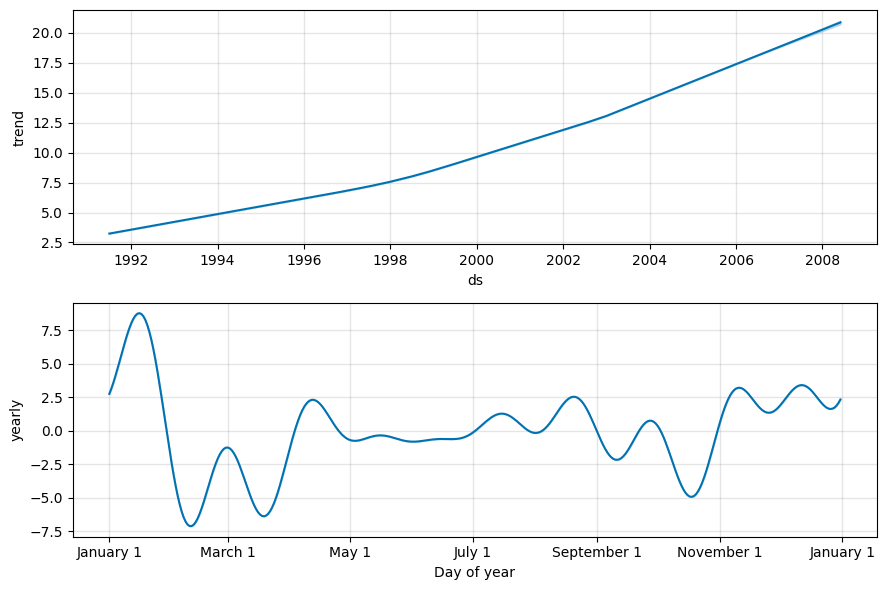

In [19]:
m.plot_components(forecast);

### Calidad de las predicciones

Evaluemos la calidad del algoritmo calculando la métrica del error para los últimos 30 días que hemos predicho. Para ello, necesitaremos las observaciones $y_i$ y los correspondientes valores predichos $\hat{y}_i$.

Vamos a ver en el objeto `previsión` que la biblioteca creado para nosotros:

In [20]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


Podemos ver que este marco de datos contiene toda la información que necesitamos excepto los valores históricos. Necesitamos unir el objeto `forecast` con los valores reales `y` del conjunto de datos original `df`. Para ello definiremos una función de ayuda que reutilizaremos más adelante:

In [21]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

Apliquemos esta función a nuestra última previsión:

In [22]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df[~cmp_df['y'].isna()]

,yhat,yhat_lower,yhat_upper,y
ds,,,,
1991-07-01,3.060319,2.220111,3.941516,3.526591
1991-08-01,3.145007,2.234474,3.974258,3.180891
1991-09-01,3.411003,2.574949,4.298378,3.252221
1991-10-01,3.873062,3.022421,4.729828,3.611003
1991-11-01,3.828005,2.942691,4.623090,3.565869
...,...,...,...,...
2008-02-01,18.688344,17.846524,19.549034,21.654285
2008-03-01,19.249352,18.401064,20.110969,18.264945
2008-04-01,19.547770,18.649982,20.350723,23.107677


Calcularemos ahora el MAPE y MAE obtenido:

In [23]:
df_t = cmp_df[~cmp_df['y'].isna()]
    
# Ahora calculamos los valores de e_i y p_i según las fórmulas dadas en el artículo anterior.
df_t['e'] = df_t['y'] - df_t['yhat']
df_t['p'] = 100 * df_t['e'] / df_t['y']

print("MAPE", np.mean(np.abs(df_t['p'])))
print("MAE", np.mean(np.abs(df_t['e'])))

MAPE 7.216843212548135
MAE 0.812935067861126


In [24]:
test_forecast = pd.concat([df[-prediction_size:],forecast[['yhat', 'yhat_lower', 'yhat_upper']][-prediction_size:]], axis=1)

# Ahora calculamos los valores de e_i y p_i según las fórmulas dadas en el artículo anterior.
test_forecast['e'] = test_forecast['y'] - test_forecast['yhat']
test_forecast['p'] = 100 * test_forecast['e'] / test_forecast['y']

print("MAPE", np.mean(np.abs(test_forecast['p'])))
print("MAE", np.mean(np.abs(test_forecast['e'])))

MAPE 11.859038603470278
MAE 2.5943524869718657


# Alternativas (Nixtla)

Nixtla es una empresa que trabaja en el dominio del forecast en exclusiva. Ofrece una plataforma de fácil uso llamada MLForecast donde se emplean modelos de ML para realizar las predicciones: https://github.com/Nixtla/mlforecast

Se trata de una librería que permite automatizar la ingeniería de características necesarias empleando modelos como proveedores de predicción.

In [61]:
# !pip install mlforecast

También son los creadores de TimeGPT, pero esto lo veremos más adelante.

## Resumen

Hemos echado un vistazo a *Prophet*, una biblioteca de predicción de código abierto orientada específicamente a las series temporales empresariales. También hemos realizado algunas prácticas de predicción de series temporales.

Como hemos visto, la biblioteca Prophet no hace maravillas, y sus predicciones out-of-box no son [ideales](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization). Sigue correspondiendo al científico de datos explorar los resultados de la predicción, ajustar los parámetros del modelo y transformar los datos cuando sea necesario.

Sin embargo, esta biblioteca es fácil de usar y personalizar. La sola posibilidad de tener en cuenta los días anormales que el analista conoce de antemano podría marcar la diferencia en algunos casos.

En definitiva, merece la pena que la biblioteca Prophet forme parte de su caja de herramientas analíticas.

Referencias:

- Official [Prophet repository](https://github.com/facebookincubator/prophet) on GitHub.
- Official [Prophet documentation](https://facebookincubator.github.io/prophet/docs/quick_start.html).
- Sean J. Taylor, Benjamin Letham ["Forecasting at scale"](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf) — scientific paper explaining the algorithm which lays the foundation of `Prophet`.
- [Forecasting Website Traffic Using Facebook’s Prophet Library](http://pbpython.com/prophet-overview.html) — `Prophet` overview with an example of website traffic forecasting.
- Rob J. Hyndman, George Athanasopoulos ["Forecasting: principles and practice"](https://www.otexts.org/fpp) – a very good online book about time series forecasting.